In [32]:
import os, sys, glob, re
import datetime as dt
import numpy as np
from matplotlib.dates import date2num
import h5py

from sklearn import decomposition as decomp
import nimfa
#from scipy import signal

#from modest_image import imshow
#from calendar import monthrange

In [33]:
sys.path.insert(0,'../mi_instrument')
from mi.instrument.kut.ek60.ooicore import zplsc_b

In [34]:
sys.path.insert(0,'..')
import db_diff
import decomp_plot

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
%matplotlib inline

## Set up range of date to load data

In [13]:
date_start = dt.date(2015,8,17)
date_end = dt.date(2015,10,17)
date_wanted = [(date_start+dt.timedelta(days=xx)).strftime('%Y%m%d') for xx in range((date_end-date_start).days + 1)]

In [14]:
data_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/'
save_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_new/'
save_fname = '%s-%s' % (date_start.strftime('%Y%m%d'),date_end.strftime('%Y%m%d'))

In [15]:
# Set param
ping_time_param_names = ["hour_all","min_all","sec_all"]
ping_time_param_vals = (range(24),range(20),range(0,60,5))
ping_time_param = dict(zip(ping_time_param_names,ping_time_param_vals))
ping_per_day = len(ping_time_param['hour_all'])*len(ping_time_param['min_all'])*len(ping_time_param['sec_all'])

ping_bin_range = 40
depth_bin_range = 10
tvg_correction_factor = 2

ping_per_day_mvbs = ping_per_day/ping_bin_range

## Load and compile data

`db_diff.raw2MVBS_daterange` will do the following for the range of dates specified above:
- Unpack .raw file
- Estimate noise and clean up data
- Extract designated pings
- Calculate MVBS

Probably better to change to raw2MVBS for each day and then combine.

To save time here I load directly the HDF5 file that was calculated before.

In [16]:
#db_diff.raw2MVBS_daterange(date_wanted,data_path,save_path,save_fname,ping_time_param,ping_bin_range,depth_bin_range,tvg_correction_factor)

In [17]:
f = h5py.File(os.path.join(save_path,'%s_MVBS.h5' %save_fname),"r")
MVBS = np.array(f['MVBS'])

The echogram doesn't look so nice when plotting all 62 days together.

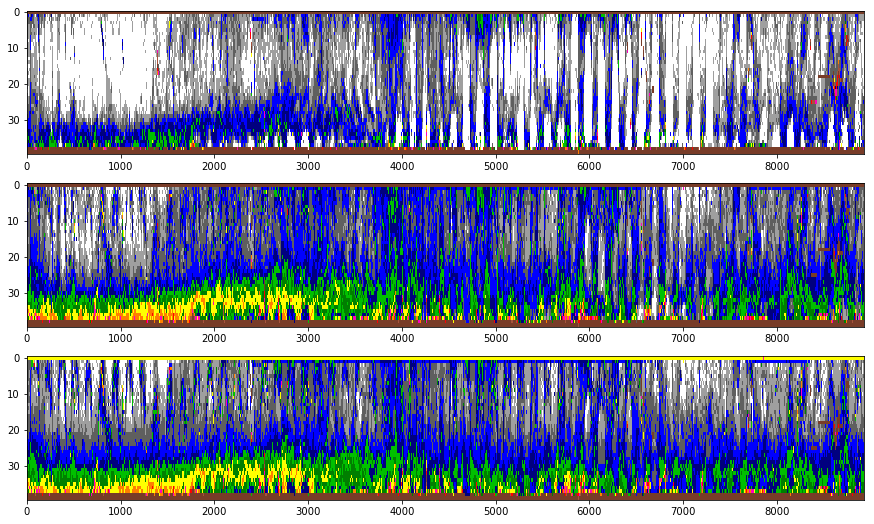

In [18]:
fig,ax = plt.subplots(3,1,figsize=(15,9))
ax[0].imshow(MVBS[0,:,:],aspect='auto',cmap=db_diff.e_cmap,norm=db_diff.e_norm)
ax[1].imshow(MVBS[1,:,:],aspect='auto',cmap=db_diff.e_cmap,norm=db_diff.e_norm)
ax[2].imshow(MVBS[2,:,:],aspect='auto',cmap=db_diff.e_cmap,norm=db_diff.e_norm)

But the echogram structures are easier to see if only plotting out a shorter section. Below we plot the last 5 days, in which there are lots of returns from the profiler. Including these returns or not makes a difference in how the NMF decompose the data matrix.

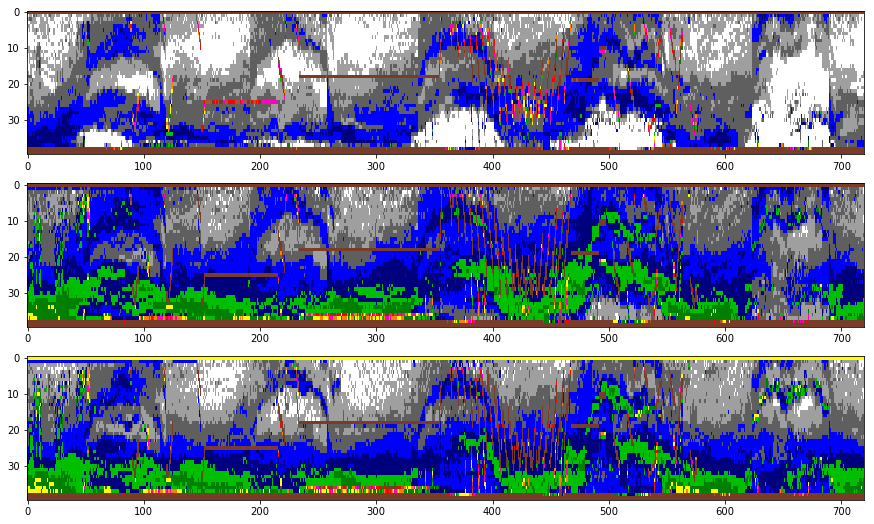

In [20]:
plot_start_day = 57
plot_range_day = 5
fig,ax = plt.subplots(3,1,figsize=(15,9))
ax[0].imshow(MVBS[0,:,ping_per_day_mvbs*plot_start_day+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',cmap=db_diff.e_cmap,norm=db_diff.e_norm)

ax[1].imshow(MVBS[1,:,ping_per_day_mvbs*plot_start_day+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',cmap=db_diff.e_cmap,norm=db_diff.e_norm)
ax[2].imshow(MVBS[2,:,ping_per_day_mvbs*plot_start_day+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',cmap=db_diff.e_cmap,norm=db_diff.e_norm)

************************
## NMF in the linear domain

The decomposition seems to be dominated by echoes from the profiler when running NMF in the linear domain. I tested how the decomposition would change depending on if or not the last 3 days of data are included in the data for decomposition.

### _Not_ include data from the last 3 days

In all decomposition below I took out the first and last 2 depth bins. The first depth bin is blank-out region of the transducer. The last 2 depth bins are returns from the sea surface. They seem to throw off NMF and result into one strong component that contains data from these depth bins.
In the first test below I did not include data from the last 3 days in the decomposition (the profiler echoes are very strong in day -2).

In [22]:
mvbs = 10**(MVBS[:,1:-2,:-3*ping_per_day_mvbs]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

n_comp = 5
nmf_59 = decomp.NMF(n_components=n_comp)
W_59 = nmf_59.fit_transform(mvbs_long)
H_59 = nmf_59.components_
V_59 = H_59.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

In [23]:
(H_59.shape,W_59.shape)

((5, 15984), (59, 5))

Below let's first check the components from NMF (H). It seems like that the algorithm treats the profiler echoes as signal and nothing else... and the actual movements of the animals were not driving the decomposition.

In [71]:
reload(decomp_plot)

<module 'decomp_plot' from '../decomp_plot.py'>

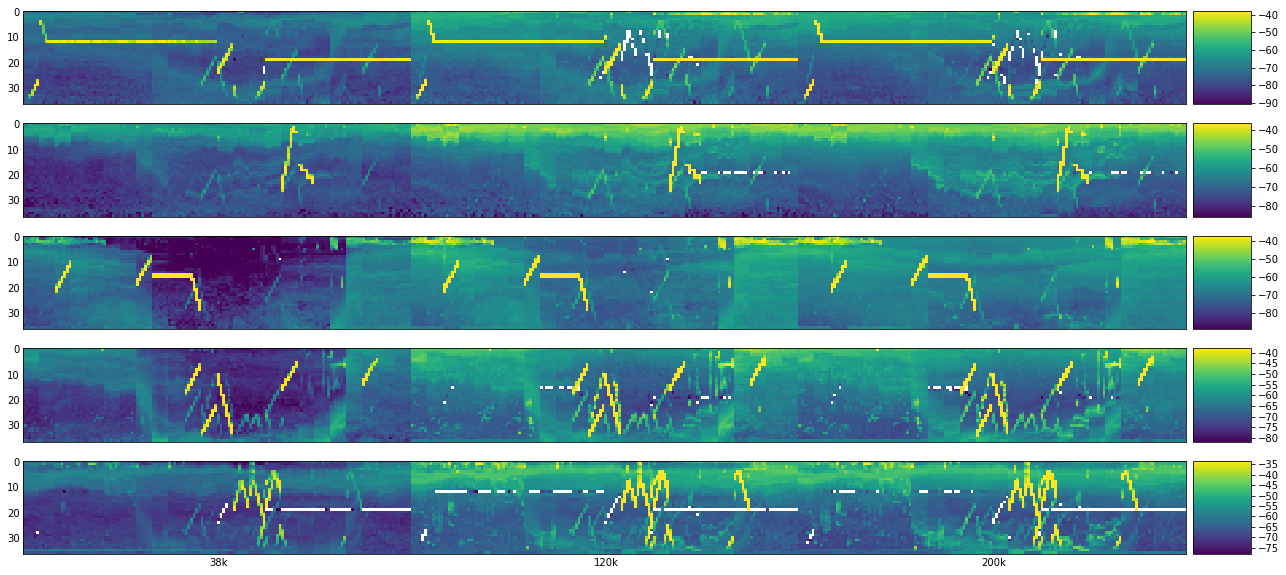

In [59]:
decomp_plot.plot_comp(V_59,n_comp,ping_per_day_mvbs,figsize_input=(22,10))

Below are the coefficients/mapping/coactivation for the components (W). The coefficients are plotted in the log domain so that we could see small values. It is obvious that each of the components was activated mostly just once (i.e., in one day within the 60 days of data).

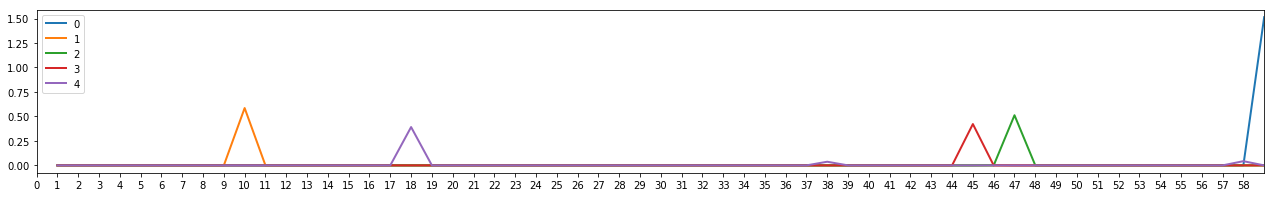

In [57]:
decomp_plot.plot_coef(W_59,n_comp)

To check if these mappings make sense, below I check the original data for a few days where there is a peak from one of the components.

We can see that for Day 10, the max-activated component (component #1 in the above figure) does correspond with the dominant profiler echo pattern for that day.

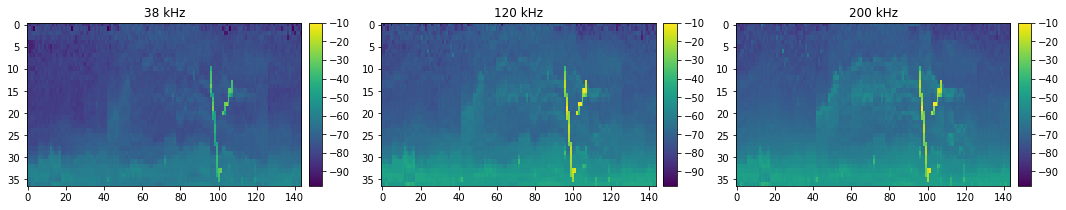

In [61]:
dday = 10
decomp_plot.plot_single_day(MVBS,dday,ping_per_day_mvbs)

The mapping seems to work well for Day 18 and Day 59 as well. Day 18 corresponds with component #4, and Day 59 correspond with component #0).

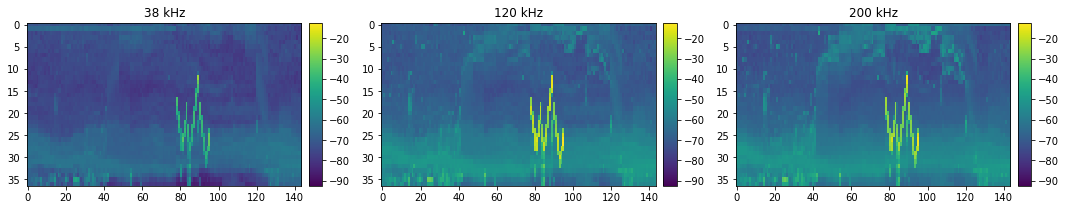

In [62]:
dday = 18
decomp_plot.plot_single_day(MVBS,dday,ping_per_day_mvbs)

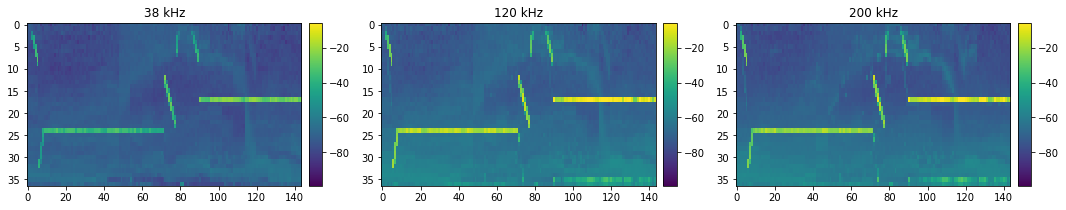

In [63]:
dday = 59
decomp_plot.plot_single_day(MVBS,dday,ping_per_day_mvbs)

But for Day 38 the mapping doesn't seem to work as well.

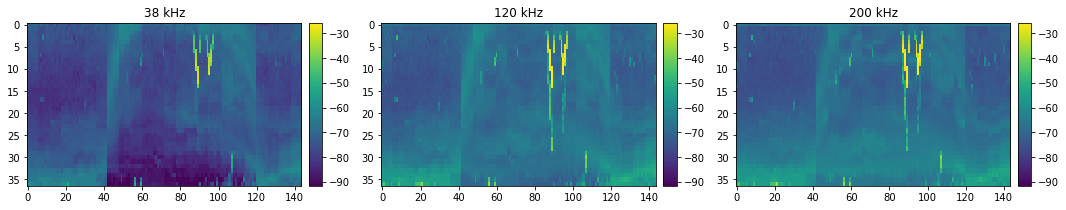

In [64]:
dday = 38
decomp_plot.plot_single_day(MVBS,dday,ping_per_day_mvbs)

Below I try to compare the original and reconstructed data. The results are in general pretty good... Although it does seem like that the reconstruction very often would introduce noise into the echogram (spurious lines resulting from some of the components).

First I calculate the transformed data and manipulated the matrix dimension for plotting.

In [72]:
D_59 = nmf_59.inverse_transform(W_59).copy()
D_59_sep,D_59_plot = decomp_plot.separate_transform_result(D_59,mvbs,ping_per_day_mvbs,log_opt=1)

In [78]:
reload(decomp_plot)

<module 'decomp_plot' from '../decomp_plot.py'>

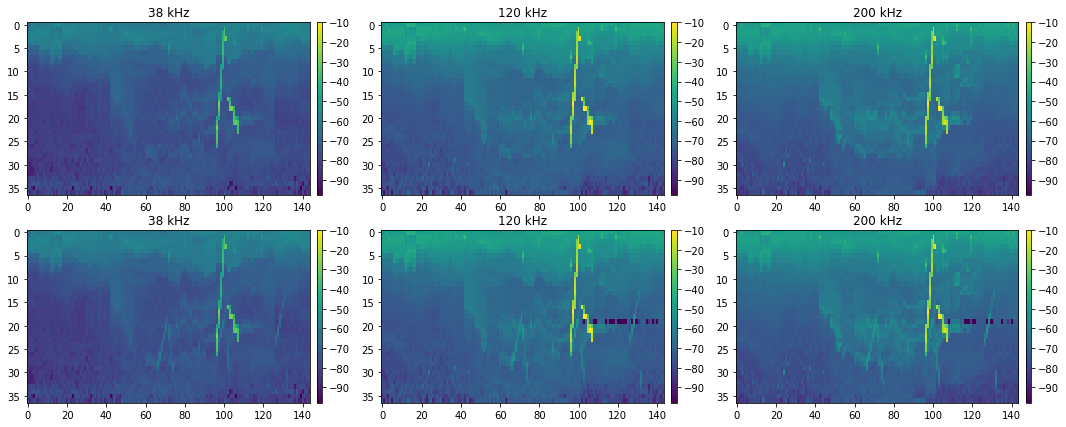

In [79]:
dday = 10
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_59_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

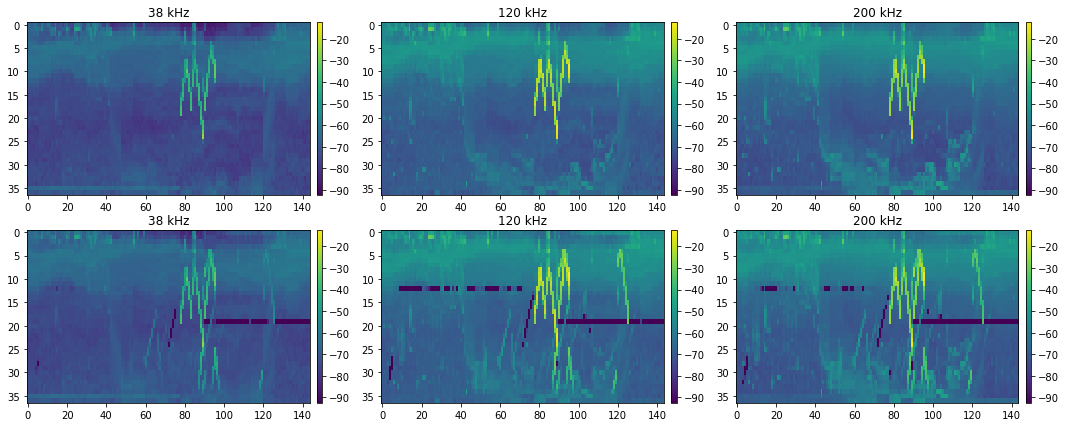

In [80]:
dday = 18
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_59_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

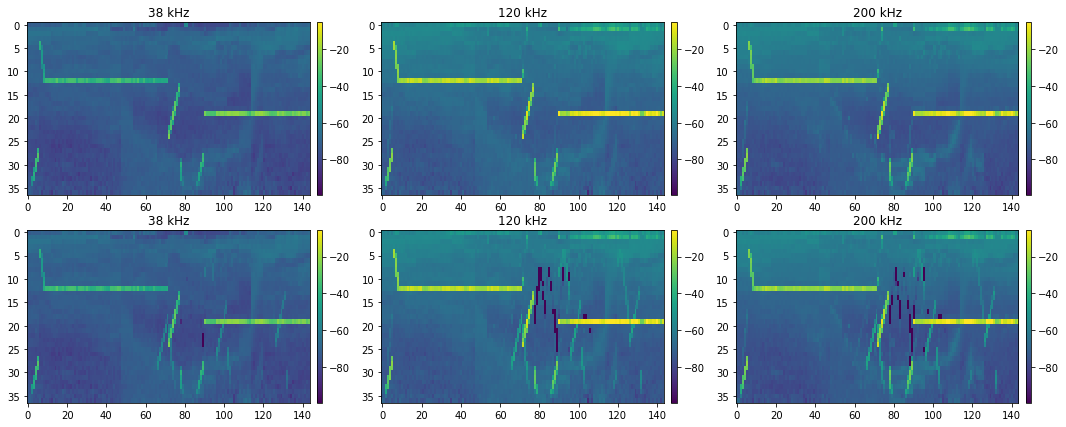

In [81]:
dday = 59
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_59_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

What's interesting is that the NMF decomposition seems to capture the background animal movements pretty well too, even though the energy is really dominated by the profiler echoes.

However for days where there is no strong profiler echoes, the rescontruction doesn't work so well...

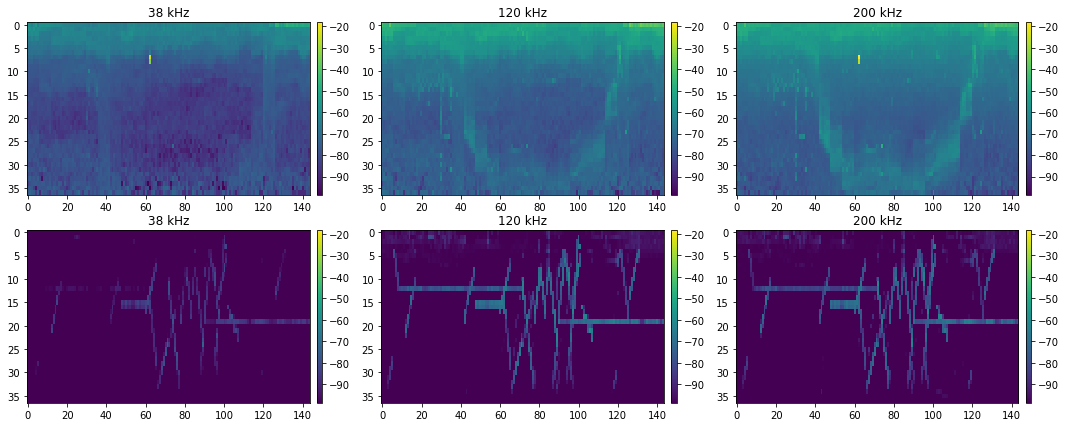

In [82]:
dday = 5
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_59_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

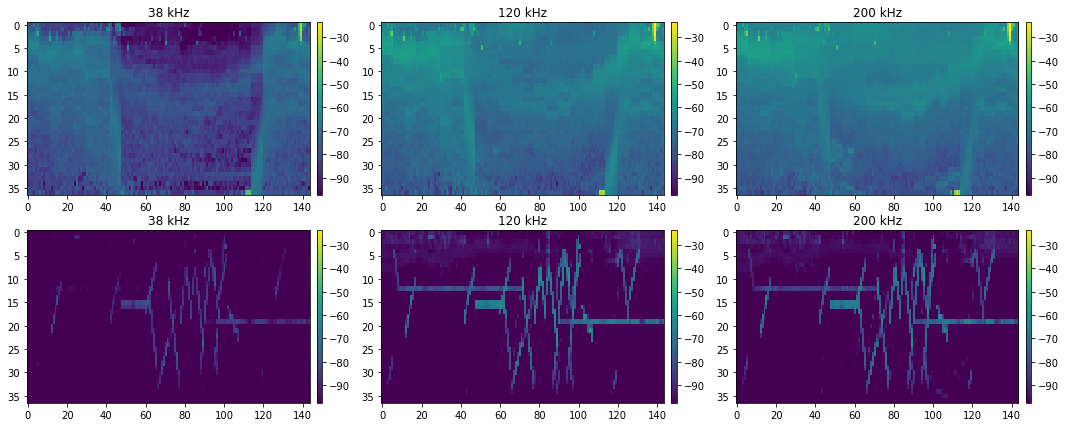

In [83]:
dday = 50
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_59_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

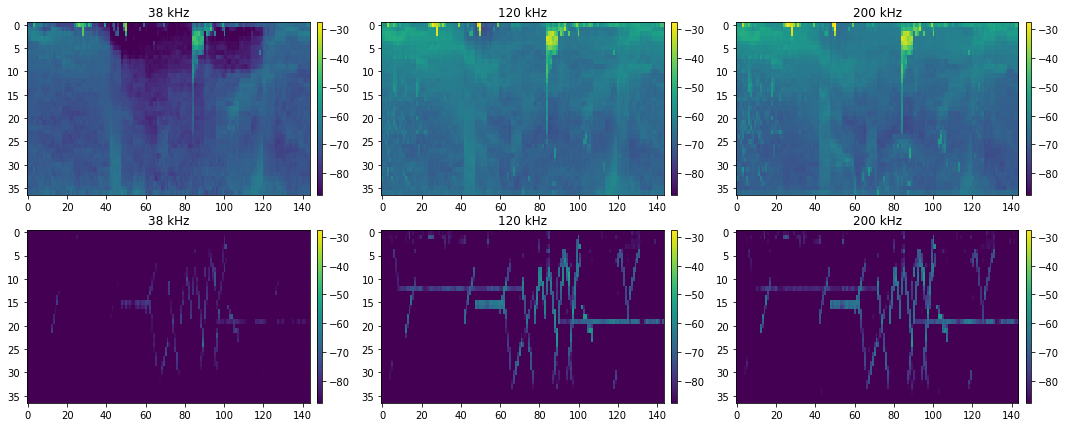

In [84]:
dday = 30
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_59_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

### Include data from all days

If we include data from the last 3 days in the decomposition the results are quite a bit messier in terms of having the profiler echoes dominating the components.

In [88]:
mvbs = 10**(MVBS[:,1:-2,:]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

n_comp = 5
nmf_61 = decomp.NMF(n_components=n_comp)
W_61 = nmf_61.fit_transform(mvbs_long)
H_61 = nmf_61.components_
V_61 = H_61.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

D_61 = nmf_61.inverse_transform(W_61).copy()
D_61_sep,D_61_plot = decomp_plot.separate_transform_result(D_61,mvbs,ping_per_day_mvbs,log_opt=1)

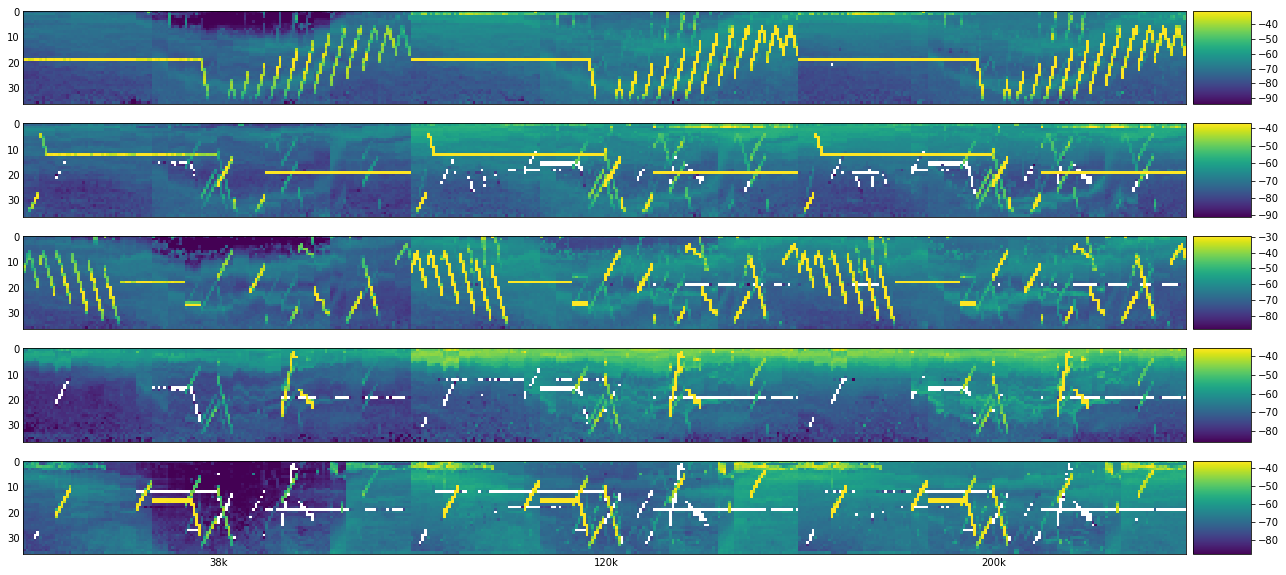

In [89]:
decomp_plot.plot_comp(V_61,n_comp,ping_per_day_mvbs,figsize_input=(22,10))

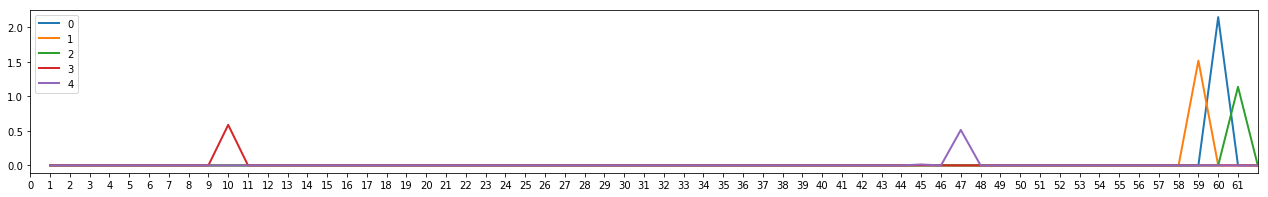

In [90]:
decomp_plot.plot_coef(W_61,n_comp)

Looking at the reconstruction again, it does seem like that the reconstruction very often would introduce noise into the echogram (spurious lines resulting from some of the components). In general, it seems like by including the very high-energy profiler echoes in the last 3 days into the decopmosition, the resulting decomposition and reconstruction results are worse than without them.

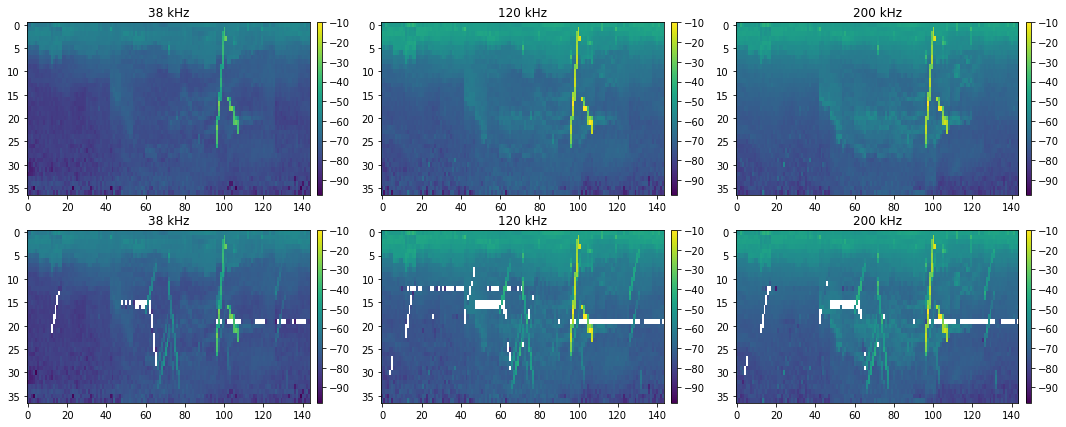

In [91]:
dday = 10
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_61_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

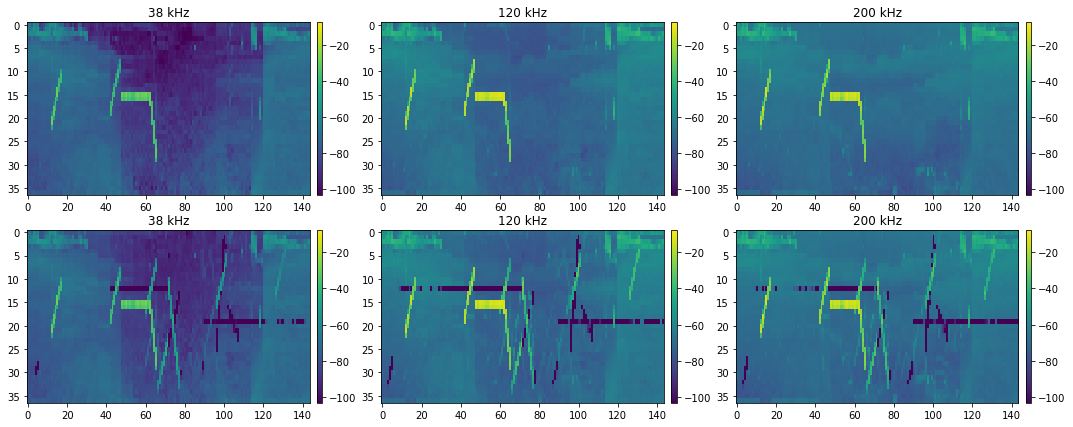

In [92]:
dday = 47
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_61_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

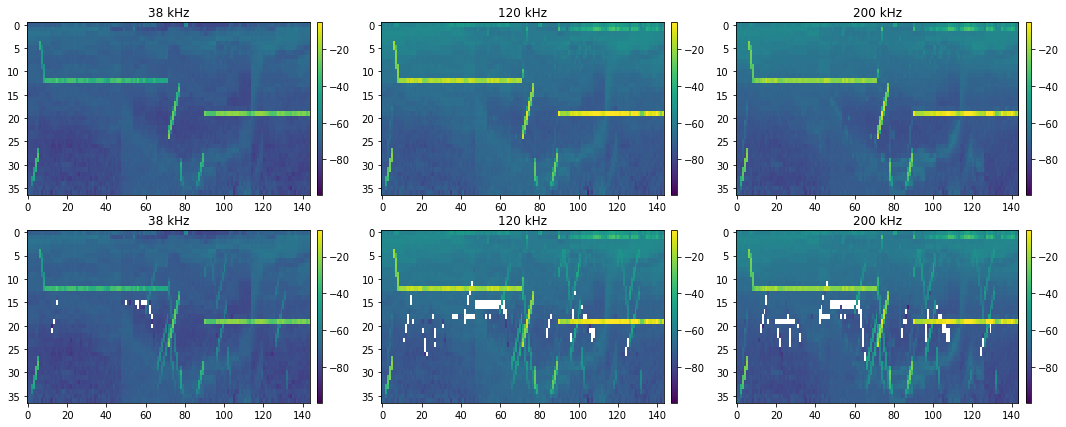

In [93]:
dday = 59
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_61_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

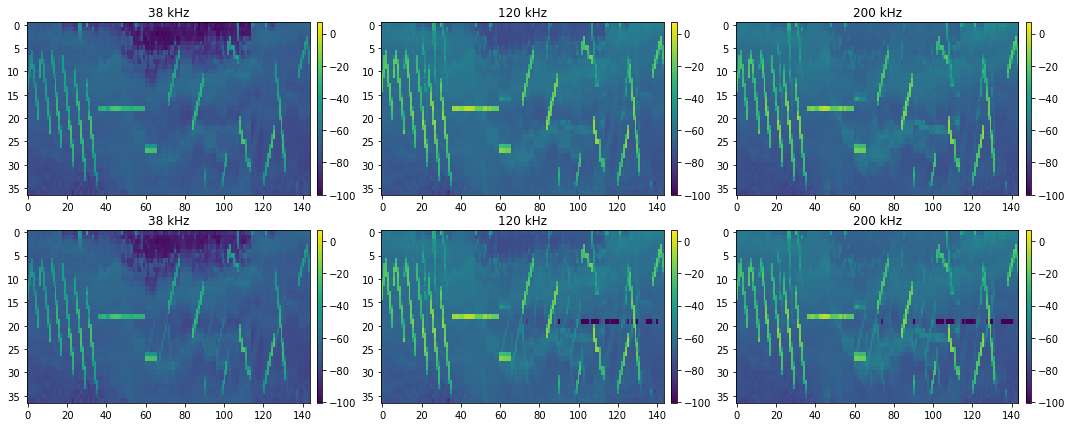

In [94]:
dday = 61
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_61_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

For the days without strong profiler echoes, it seems like that the reconstruction results are in general pretty bad... this is consistent as we have seen before for results from using 59 days for decomposition.

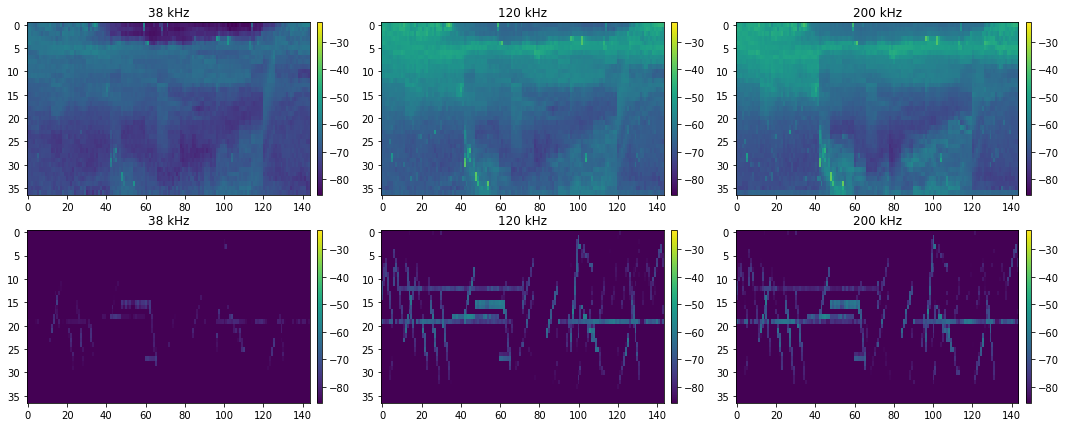

In [95]:
dday = 20
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_61_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

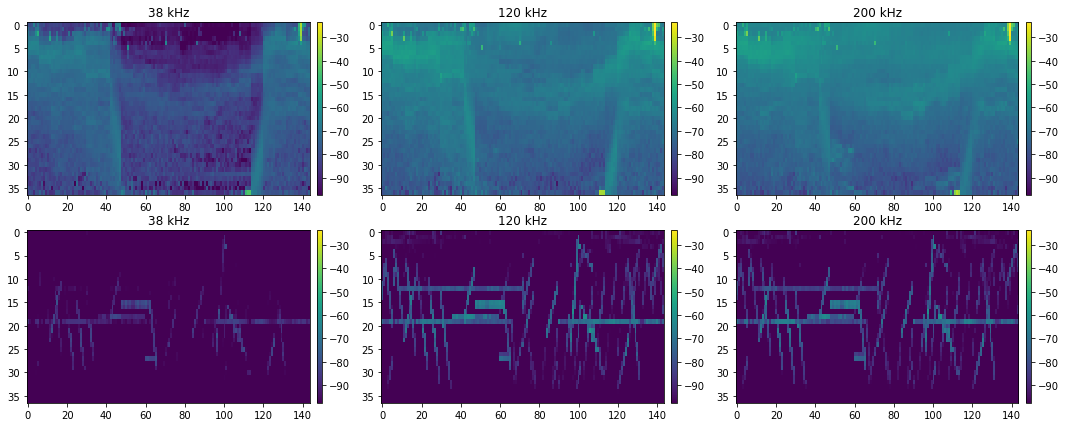

In [96]:
dday = 50
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_61_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

### Include data from all days but with more number of components¶

In [97]:
mvbs = 10**(MVBS[:,1:-2,:]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

n_comp = 8
nmf_61_8 = decomp.NMF(n_components=n_comp)
W_61_8 = nmf_61_8.fit_transform(mvbs_long)
H_61_8 = nmf_61_8.components_
V_61_8 = H_61_8.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

D_61_8 = nmf_61_8.inverse_transform(W_61_8).copy()
D_61_8_sep,D_61_8_plot = decomp_plot.separate_transform_result(D_61_8,mvbs,ping_per_day_mvbs,log_opt=1)

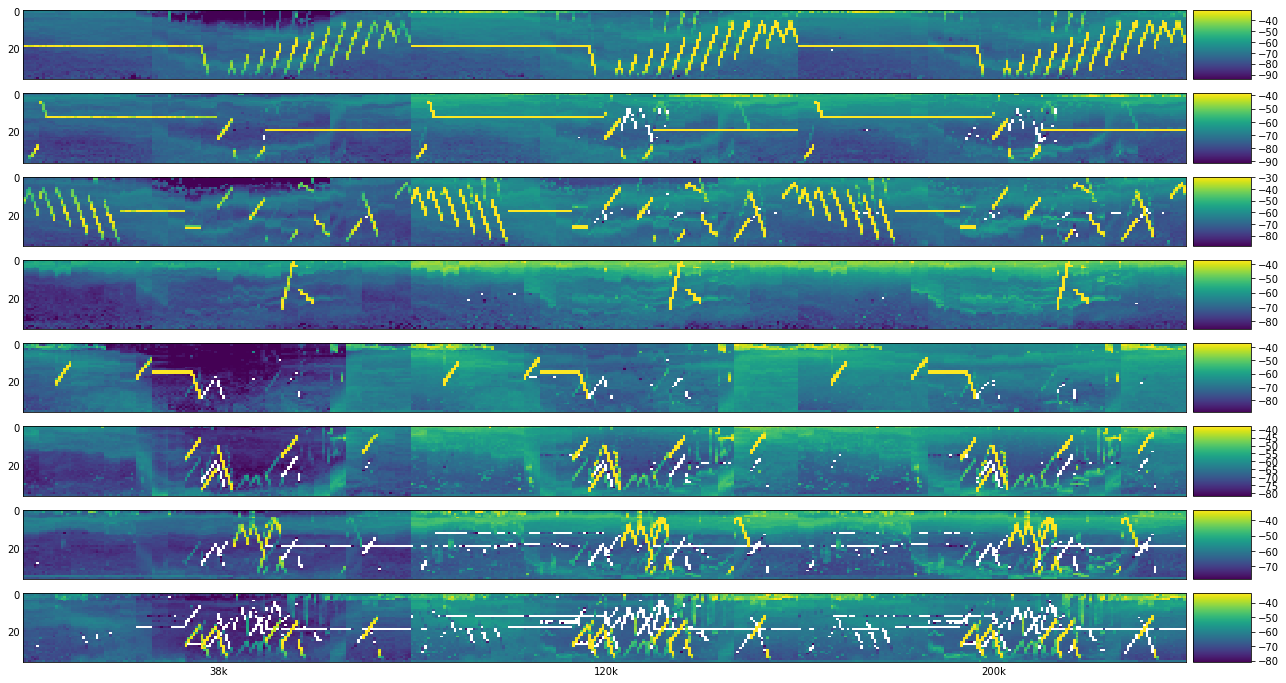

In [98]:
decomp_plot.plot_comp(V_61_8,n_comp,ping_per_day_mvbs,figsize_input=(22,12))

Below is the coefficients from NMF with 8 components.

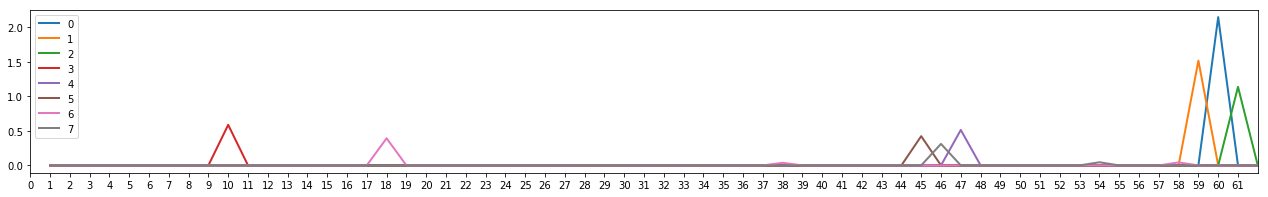

In [99]:
decomp_plot.plot_coef(W_61_8,n_comp)

When compared with coefficients from NMF with 5 components, it seems like whne less number of components are specified, instead of combining features, NMF just push some additional components to be noise, and those days with strong but perhaps slightly weaker profiler echoes do not show up.

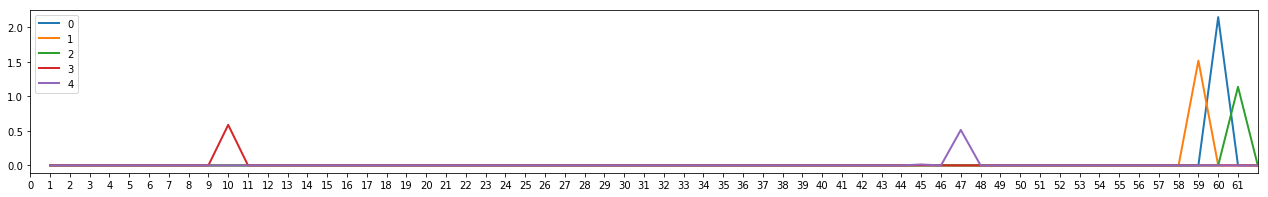

In [100]:
decomp_plot.plot_coef(W_61,n_comp)

### Compare how the number of components impacts the reconstruction results

Below I compare how the original and reconstructed data are different for using 5-component or 8-component NMF.
For Day 18 where there is no peaked coefficient in 5-component NMF decomposition, the 8-component NMF does a lot better.

First: comparison between original data and reconstruction from __5-component__ decomposition:

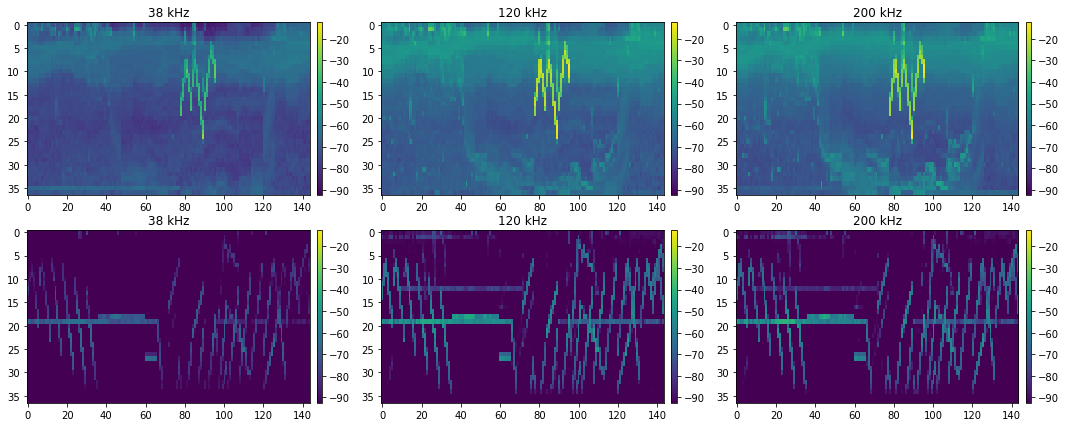

In [101]:
dday = 18
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_61_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

And then comparison between original data and reconstruction from __8-component__ decomposition:

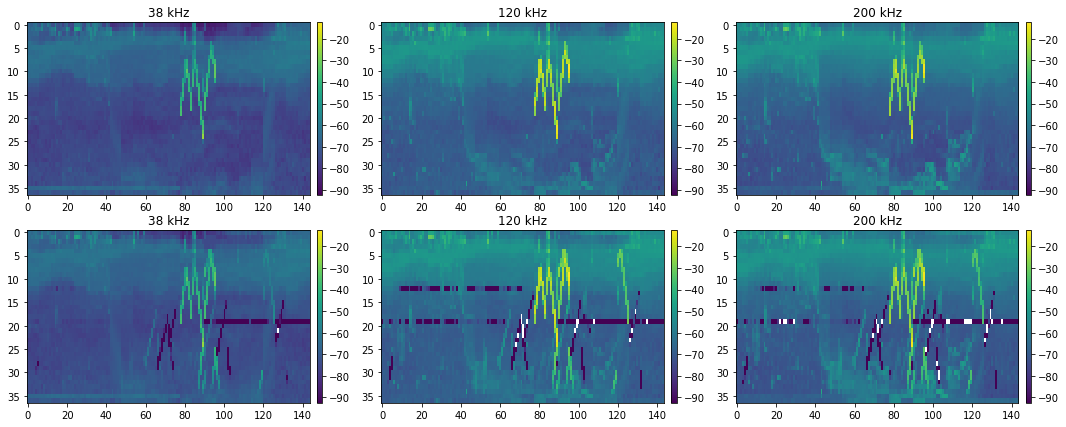

In [102]:
dday = 18
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_61_8_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

For Day 45 where there is no peaked coefficient in 5-component NMF decomposition, the 8-component NMF does a lot better.

First: comparison between original data and reconstruction from 5-component decomposition:

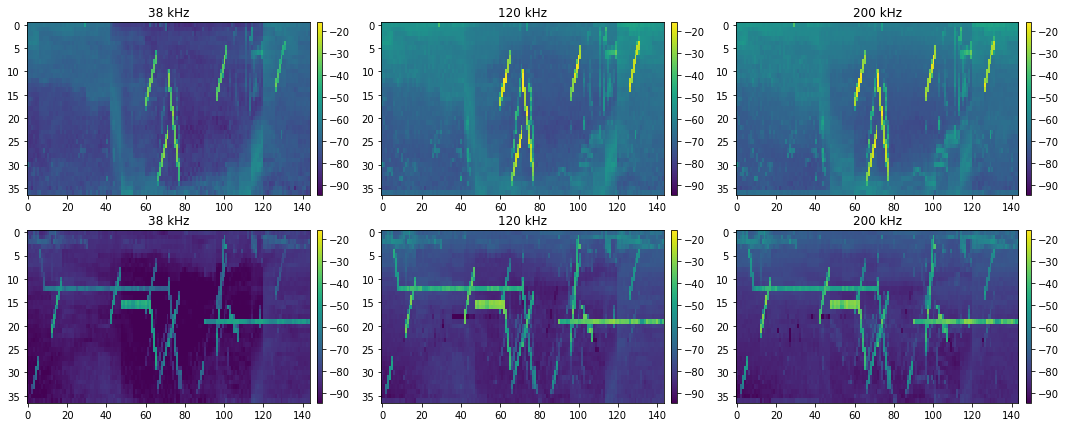

In [103]:
dday = 45
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_61_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

And then comparison between original data and reconstruction from 8-component decomposition:

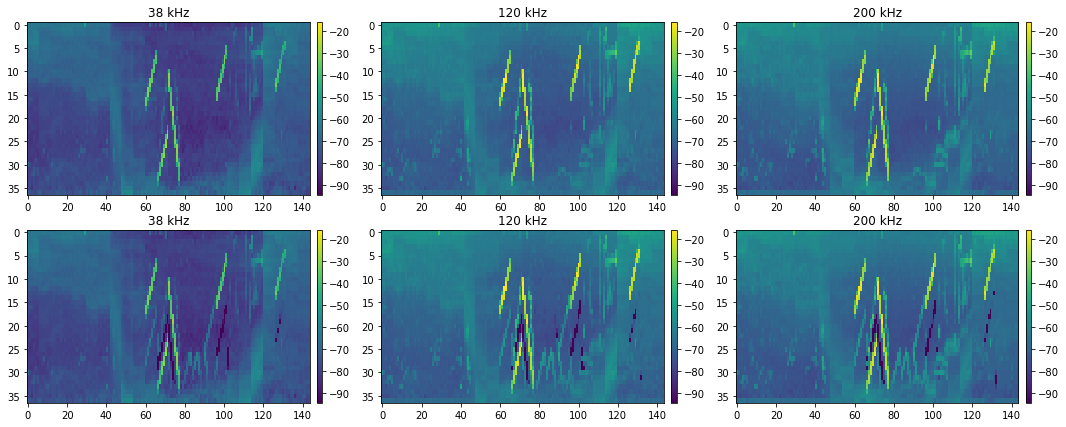

In [104]:
dday = 45
decomp_plot.plot_cmp_data_decomp(10*np.log10(mvbs),D_61_8_plot,dday,ping_per_day_mvbs,figsize_input=(18,7))

From the above comparison seems like it can be concluded that:
* The profiler echoes were captured in the components as well as the background animal echoes, but only the pattern in the day coincides with strong profiler echoes is captured.
* Reconstructions for days without strong profiler echoes look very bad!